## Problem 1 Autoencoder

We use a convolutional autoencoder to encode and decode images in the Fashion-MNIST dataset. The encoding piece uses 3 convolutional layrers of dimensionaliy 16, 8 and 8 and each kernel is of size 3x3. We use max-pooling from a 2x2 matrix after each convolutional layer. The decoder piece is simply the reverse of the encoder, uses 3 conv layers of dimensionality 8, 8 and 16 with each layer followed by an up-sampling layer of size 2x2 matrix.

In [0]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K


input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.


### Load the data from the fashion MNIT dataset, already available in Keras.

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

### Fit the auto-encoder. We use 50 epochs and batch size of 128.

In [0]:
from keras.callbacks import TensorBoard

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 167us/step - loss: 0.3735 - val_loss: 0.3320
Epoch 2/50
60000/60000 [==============================] - 9s 144us/step - loss: 0.3251 - val_loss: 0.3196
Epoch 3/50
60000/60000 [==============================] - 9s 144us/step - loss: 0.3152 - val_loss: 0.3124
Epoch 4/50
60000/60000 [==============================] - 9s 147us/step - loss: 0.3098 - val_loss: 0.3088
Epoch 5/50
60000/60000 [==============================] - 9s 143us/step - loss: 0.3059 - val_loss: 0.3103
Epoch 6/50
60000/60000 [==============================] - 8s 141us/step - loss: 0.3033 - val_loss: 0.3038
Epoch 7/50
60000/60000 [==============================] - 8s 137us/step - loss: 0.3014 - val_loss: 0.3004
Epoch 8/50
60000/60000 [==============================] - 8s 136us/step - loss: 0.2999 - val_loss: 0.2989
Epoch 9/50
60000/60000 [==============================] - 8s 139us/step - loss: 0.2986 - val_loss: 0.

### Plot the training and validation loss to confirm that the model was indeed converging. We can see that that as the training and validation loss are both decreasing with each epoch.

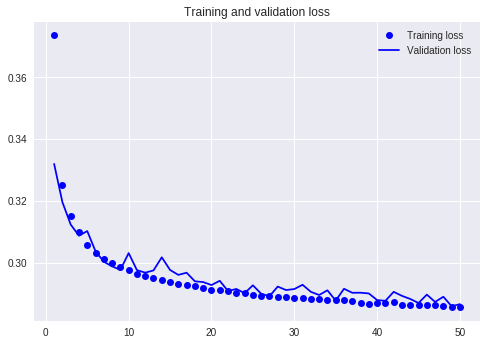

In [0]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Decode the results and display the original images along with the reconstructed images. The reconstruction looks pretty good.

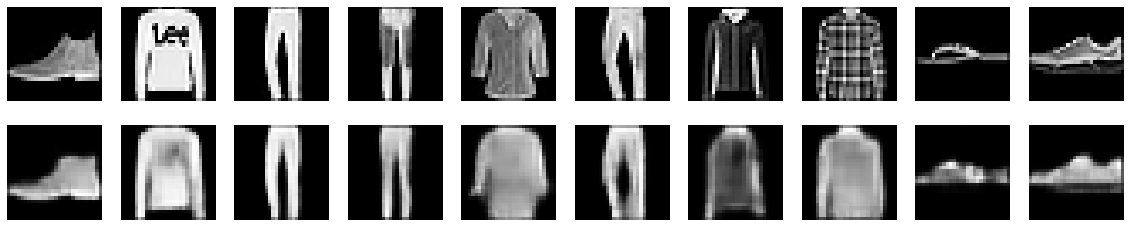

In [0]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Problem 2 Image Classification


## 2.1 Using ConvNets
We use CNNs in this problem to classify the various clothing items in the fashion MNIST dataset. We get a final accuracy of 90.85% on the test set. The architecture of the CNN is as follows.
1. A 2D convolution layer of 32 kernels of size 3x3.
2. Max polling over a 2x2 area to downsample the output.
3. Another 2D convolution layer of 32 kernels of size 3x3.
4. Another Max polling over a 2x2 area to downsample the output.
5. Flatten the output to feed to the first dense later of 84 neurons.
6. A final dense later of 10 neurons corresponding to the 10 possible classes.
7. Use softmax activation and categorical crossentropy since this is a multi class classification problem.

The choices for the size of the convolution layers and dense layer are standard baseline numbers for image classification problems. We get good results with this numbers, although, there is definitely scope for tinkering with them to get even better accuracy.

In [0]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

from keras.models import Sequential
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization

from PIL import Image

In [0]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

y_train = np_utils.to_categorical(y_train, 10) # into to categorical, there are 10 categories in the dataset
y_test = np_utils.to_categorical(y_test, 10)

In [0]:
# =============================
#  Setting up ConvNet Architecture
# ============================
model = Sequential()

model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid', input_shape=(28,28,1)))

model.add(Flatten())
model.add(Dense(84))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 3, 3, 32)          9248      
_________________________________________________________________
flatten_6 (Flatten)          (None, 288)               0         
__________

In [0]:
# =============================
#  Training the model
# ============================
l_rate = 1
sgd = SGD(lr=l_rate, momentum=0.0, decay=0.0, nesterov=False)
# model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy']) -takes a long time to converge
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=50,
          verbose=True, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 23s 392us/step - loss: 0.6003 - acc: 0.7763 - val_loss: 0.4261 - val_acc: 0.8463
Epoch 2/50
60000/60000 [==============================] - 24s 403us/step - loss: 0.4196 - acc: 0.8458 - val_loss: 0.3673 - val_acc: 0.8682
Epoch 3/50
60000/60000 [==============================] - 24s 404us/step - loss: 0.3808 - acc: 0.8601 - val_loss: 0.3377 - val_acc: 0.8788
Epoch 4/50
60000/60000 [==============================] - 24s 396us/step - loss: 0.3578 - acc: 0.8681 - val_loss: 0.3555 - val_acc: 0.8607
Epoch 5/50
60000/60000 [==============================] - 24s 398us/step - loss: 0.3367 - acc: 0.8745 - val_loss: 0.3046 - val_acc: 0.8872
Epoch 6/50
60000/60000 [==============================] - 24s 400us/step - loss: 0.3268 - acc: 0.8793 - val_loss: 0.3062 - val_acc: 0.8879
Epoch 7/50
60000/60000 [==============================] - 24s 403us/step - loss: 0.3186 - acc: 0.8830 - val_loss: 0.

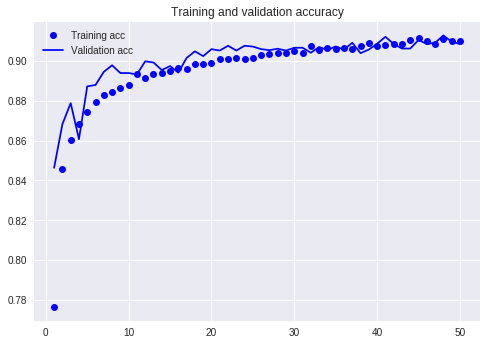

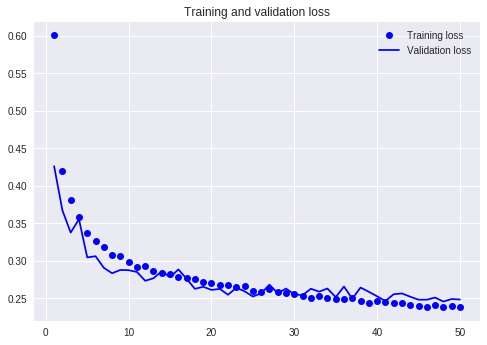

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 2.2 Transfer Learning
We use the VGG16 model and use all the layers except the output layer. The input images need to be reshaped from 28x28 to 32x32 for VGG16. At the end of training for 100 epochs we get a validation set accuracy of 85.7%.

In [0]:

from keras.applications import VGG16, VGG19
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Flatten, LeakyReLU
from keras.optimizers import RMSprop
from keras import callbacks
from keras.datasets import mnist
from keras.datasets import fashion_mnist
import numpy as np
from keras.utils import np_utils

In [0]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

image_len_width = 28
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), image_len_width, image_len_width, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), image_len_width, image_len_width, 1))  # adapt this if using `channels_first` image data format

y_train = np_utils.to_categorical(y_train, 10) # into to categorical, there are 10 categories in the dataset
y_test = np_utils.to_categorical(y_test, 10)


train_X=np.dstack([x_train] * 3)
test_X=np.dstack([x_test]*3)
# Reshape images as per the tensor format required by tensorflow
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape


((60000, 28, 28, 3), (10000, 28, 28, 3))

In [0]:
# Resize the images 48*48 as required by VGG16
image_len_width_reshaped = 32
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((image_len_width_reshaped,image_len_width_reshaped))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((image_len_width_reshaped,image_len_width_reshaped))) for im in test_X])

train_X = train_X.astype('float32') / 255.
test_X = test_X.astype('float32') / 255.

#train_x = preprocess_input(x)
train_X.shape, test_X.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

In [0]:
from keras.applications import VGG19
# conv_base = VGG19(weights="imagenet",include_top=False,input_shape=(image_len_width_reshaped,image_len_width_reshaped,3))
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))
conv_base.trainable = False
"""
model = Sequential()
model.add(conv_base)
model.add(Flatten())
#model.add(Dense(256, activation="relu"))
#
model.add(Dense(512, activation='relu', input_dim=(4*4*512)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(10, activation="softmax"))
model.summary()
"""


model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [0]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"]) #RMSprop(1e-4)
if False:
    # Incorporating reduced learning and early stopping for callback
    reduce_learning = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        verbose=1,
        mode='auto',
        epsilon=0.0001,
        cooldown=2,
        min_lr=0)

    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=7,
        verbose=1,
        mode='auto')

    callbacks = [reduce_learning, early_stopping]

In [0]:
history = model.fit(train_X, y_train, epochs=100, validation_data=(test_X, y_test), verbose=True, batch_size=512) #steps_per_epoch=100, validation_steps=25, 

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 17s 281us/step - loss: 0.9180 - acc: 0.6912 - val_loss: 0.6494 - val_acc: 0.7754
Epoch 2/100
60000/60000 [==============================] - 16s 270us/step - loss: 0.5878 - acc: 0.7907 - val_loss: 0.5873 - val_acc: 0.7917
Epoch 3/100
60000/60000 [==============================] - 16s 270us/step - loss: 0.5393 - acc: 0.8052 - val_loss: 0.5551 - val_acc: 0.8008
Epoch 4/100
60000/60000 [==============================] - 16s 271us/step - loss: 0.5103 - acc: 0.8158 - val_loss: 0.5246 - val_acc: 0.8127
Epoch 5/100
60000/60000 [==============================] - 16s 271us/step - loss: 0.4877 - acc: 0.8226 - val_loss: 0.5124 - val_acc: 0.8157
Epoch 6/100
60000/60000 [==============================] - 16s 271us/step - loss: 0.4706 - acc: 0.8281 - val_loss: 0.5030 - val_acc: 0.8212
Epoch 7/100
60000/60000 [==============================] - 16s 271us/step - loss: 0.4594 - acc: 0.8320 - val_l

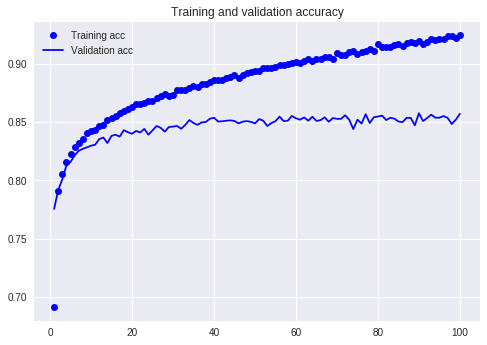

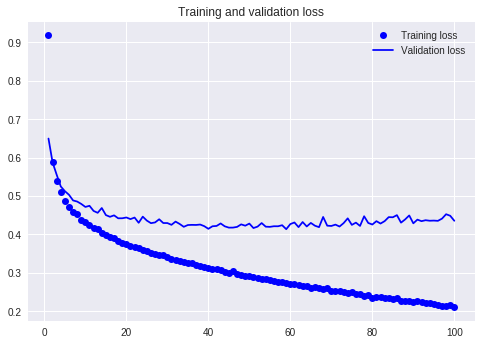

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
y_predicted = model.predict_classes(test_X)

In [0]:
y_test_classes = [list(label_list).index(1) for label_list in y_test] 
accuracy = np.mean(y_test_classes == y_predicted)
print("accuracy on the validation set is {}%".format(accuracy*100))

accuracy on the holdout set is 85.7%


## Problem 3 Text Classification
We use the benign/malicious URLs dataset and have a SimpleRNN and CNN learn to predict what type (benign/malicious) URL it is.

### Setup some utility functions that we would be using in this problem

In [0]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
    
# plot training accuracy and loss for each training epoch
def plot_model_training_results(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def plot_roc_curve(y_test, y_predicted, model_name):
  
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_predicted)
  
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve for ' + model_name + ' model')
  plt.legend(loc='best')
  plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


### 3.1 Preparing the data for deep learning
We download the data and convert it into list of numpy arrays so that it can be provided to Keras. This step is common to RNN and CNN.

In [0]:
import  pandas as pd

# by default use the Kaggle dataset, to use the homework dataset simply set
# USE_KAGGLE_DATASET = 0.

USE_KAGGLE_DATASET = 1

if not USE_KAGGLE_DATASET:
  # read the dataset and display some summary info
  benign = pd.read_csv("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt", header=None)
  benign.columns = ['url']
  benign['label'] = 0
  print(benign.info())
  display(benign.sample(5))

  malicious = pd.read_csv("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt", header=None)
  malicious.columns = ['url']
  malicious['label'] = 1
  print(malicious.info())
  display(malicious.sample(5))

  # downsample the benign entries because the malware sample are comparitively very few in number
  benign = benign.sample(5*len(malicious))

  # combine into a single dataset for the classification task
  urls = pd.concat([benign, malicious])
else:
    print("going to use Kaggle dataset")
    urls = pd.read_csv("https://raw.githubusercontent.com/aarora79/ANLY590/master/data.csv")
    urls.columns = ['url', 'label']
    urls['label'] = urls['label'].map(lambda x: 0 if x == "good" else 1)
    urls.info()
    urls.sample(5)

going to use Kaggle dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420464 entries, 0 to 420463
Data columns (total 2 columns):
url      420464 non-null object
label    420464 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [0]:
# we would be using Gensim for a quick dictionary implementation so that we dont 
# have to do code it ourselves
!pip install gensim

    100% |████████████████████████████████| 23.6MB 2.1MB/s 
    100% |████████████████████████████████| 1.4MB 15.6MB/s 
    100% |████████████████████████████████| 133kB 33.2MB/s 
    100% |████████████████████████████████| 61kB 23.3MB/s 
    100% |████████████████████████████████| 4.9MB 7.2MB/s 
    100% |████████████████████████████████| 552kB 25.3MB/s 
  Running setup.py bdist_wheel for smart-open ... - done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [0]:
from gensim.corpora import Dictionary

# covnert the combined dataset into a list of lists
# each url is exploded into individual characters 
# and then all such lists (corresponding to each row in the dataset)
# are combined into a list so that we get a list-of-lists (lol)
lol = list(urls['url'].map(lambda x: list(x)))

# let gensim do its magic
dct = Dictionary(lol)  # initialize a Dictionary
print("here is how the dictionary looks like...")
print(dct.token2id)

here is how the dictionary looks like...
{'.': 0, 'a': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'i': 7, 'm': 8, 'o': 9, 'r': 10, 't': 11, 'y': 12, 'n': 13, 'p': 14, 's': 15, 'u': 16, 'k': 17, 'l': 18, 'z': 19, 'h': 20, 'w': 21, 'b': 22, 'v': 23, '/': 24, '=': 25, '?': 26, 'x': 27, '-': 28, '1': 29, '2': 30, '9': 31, '_': 32, '0': 33, '7': 34, '8': 35, 'j': 36, '3': 37, '6': 38, '&': 39, ';': 40, 'A': 41, 'F': 42, 'G': 43, 'D': 44, 'H': 45, 'L': 46, '4': 47, '5': 48, 'q': 49, 'B': 50, 'K': 51, 'R': 52, 'N': 53, 'P': 54, 'O': 55, 'T': 56, 'M': 57, 'V': 58, 'C': 59, ':': 60, 'S': 61, 'E': 62, 'X': 63, 'J': 64, 'I': 65, '+': 66, 'á': 67, 'Q': 68, 'Y': 69, 'U': 70, 'W': 71, 'Z': 72, '%': 73, '[': 74, ']': 75, 'ó': 76, 'ñ': 77, 'í': 78, '¡': 79, '³': 80, '¿': 81, 'Â': 82, 'Ã': 83, ' ': 84, '@': 85, '~': 86, '<': 87, '>': 88, '{': 89, '}': 90, '\xad': 91, '¼': 92, '½': 93, 'à': 94, 'ï': 95, '¸': 96, 'Þ': 97, '¨': 98, 'ª': 99, 'µ': 100, 'Ò': 101, '×': 102, '¤': 103, '§': 104, '®': 105, '¹': 

In [0]:
# just to get a taste of what an encoded url would look like
test_url = ".microsoft.com"
print("here is what \"{}\" would lool like when encoded".format(test_url))
dct.doc2idx(list(test_url))

here is what ".microsoft.com" would lool like when encoded


[0, 8, 7, 2, 10, 9, 15, 9, 5, 11, 0, 2, 9, 8]

In [0]:
# do this for the entire dataset, this will be our input tensor
X = list(urls['url'].map(lambda x: dct.doc2idx(list(x))))
print("random input samples..")
#print(X.sample(5))
print(X[:10])

# output tensor
y = urls['label']

random input samples..
[[3, 7, 1, 10, 12, 9, 5, 1, 6, 1, 8, 4, 1, 3, 3, 7, 2, 11, 0, 2, 9, 8], [4, 15, 14, 3, 4, 15, 7, 6, 13, 0, 2, 9, 8, 0, 1, 16], [7, 1, 8, 1, 6, 1, 8, 4, 1, 3, 3, 7, 2, 11, 0, 2, 9, 8], [17, 1, 18, 1, 13, 11, 19, 7, 15, 0, 13, 4, 11], [15, 18, 7, 6, 20, 11, 18, 12, 9, 5, 5, 2, 4, 13, 11, 4, 10, 0, 13, 4, 11], [11, 9, 3, 3, 15, 2, 1, 10, 21, 1, 15, 20, 0, 2, 9, 8], [11, 16, 22, 4, 8, 9, 23, 7, 4, 19, 0, 2, 9, 8], [7, 14, 18, 0, 20, 17], [2, 10, 1, 2, 17, 15, 14, 7, 3, 4, 10, 0, 16, 15, 24, 11, 9, 9, 18, 22, 1, 10, 24, 7, 13, 15, 11, 1, 18, 18, 0, 14, 20, 14, 26, 14, 1, 2, 17, 25, 4, 27, 4], [14, 9, 15, 28, 17, 16, 14, 1, 13, 6, 0, 2, 9, 8, 24]]


In [0]:
# train test split
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1603)
print("length of training set X_train {}, y_train {}".format(len(X_train), len(y_train)))
print("length of training set X_test {}, y_test {}".format(len(X_test), len(y_test)))
print(X_train[0])
print(y_test[:10])

length of training set X_train 281710, y_train 281710
length of training set X_test 138754, y_test 138754
[8, 9, 10, 11, 1, 18, 7, 13, 15, 11, 10, 16, 8, 4, 13, 11, 15, 0, 2, 9, 8, 24, 8, 9, 10, 11, 1, 18, 5, 1, 49, 0, 20, 11, 8, 18]
326094    0
143606    0
12115     1
371188    0
264135    0
410944    1
81068     0
186562    0
212724    0
88914     0
Name: label, dtype: int64


### 3.1 SimpleRNN
We use a simple RNN to classify URLs into benign and malicious. As shown in the output of the code below, we get an overall classification accuracy of 96%, classfication accuracy of 98% for benign class and 86% for malicious class.

We use an embedding layer with 64 dimensions followed by a 32 layer RNN.

In [0]:
from keras.preprocessing import sequence
from keras.layers import Dense, SimpleRNN, LSTM, Embedding
from keras.models import Sequential
import numpy as np

Using TensorFlow backend.


In [0]:
# lets limit to 50 character domain names
maxlen = 50
X_train = sequence.pad_sequences(X_train, maxlen, padding="post", truncating="post")
X_test = sequence.pad_sequences(X_test, maxlen, padding="post", truncating="post")
X_train[0]

array([ 8,  9, 10, 11,  1, 18,  7, 13, 15, 11, 10, 16,  8,  4, 13, 11, 15,
        0,  2,  9,  8, 24,  8,  9, 10, 11,  1, 18,  5,  1, 49,  0, 20, 11,
        8, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [0]:
print("shape of the training dataset {}".format(X_train.shape))


shape of the training dataset (281710, 50)


In [0]:
# setup a simple RNN model. We first add an embedding layer to convert the one hot
# encoding representation into a dense vector and then simple 64 dimension RNN
max_features = len(dct)
rnn_model = Sequential()
rnn_model.add(Embedding(max_features, 64))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1, activation='sigmoid'))

In [0]:
# compile the model and print a summary
rnn_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
print(rnn_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          11456     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 14,593
Trainable params: 14,593
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# train the RNN for 100 epochs, also add a validation split of 20%
history = rnn_model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)

Train on 225368 samples, validate on 56342 samples
Epoch 1/100
225368/225368 [==============================] - 31s 139us/step - loss: 0.3497 - acc: 0.8583 - val_loss: 0.3114 - val_acc: 0.8709
Epoch 2/100
225368/225368 [==============================] - 29s 130us/step - loss: 0.2760 - acc: 0.8929 - val_loss: 0.2603 - val_acc: 0.9005
Epoch 3/100
225368/225368 [==============================] - 30s 131us/step - loss: 0.2363 - acc: 0.9118 - val_loss: 0.2305 - val_acc: 0.9128
Epoch 4/100
225368/225368 [==============================] - 30s 131us/step - loss: 0.2118 - acc: 0.9225 - val_loss: 0.3213 - val_acc: 0.8597
Epoch 5/100
225368/225368 [==============================] - 30s 131us/step - loss: 0.1957 - acc: 0.9296 - val_loss: 0.1954 - val_acc: 0.9289
Epoch 6/100
225368/225368 [==============================] - 30s 131us/step - loss: 0.1839 - acc: 0.9346 - val_loss: 0.1773 - val_acc: 0.9356
Epoch 7/100
225368/225368 [==============================] - 30s 132us/step - loss: 0.1757 - acc:

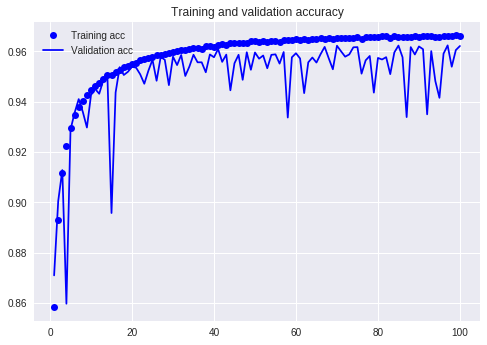

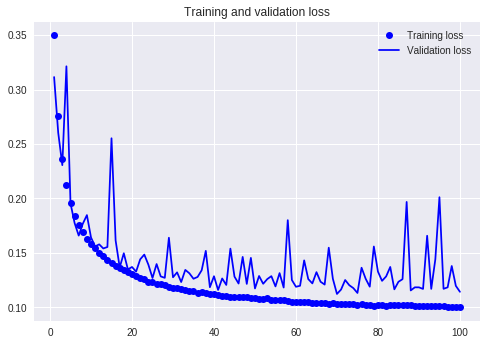

In [0]:
#plot model training results
plot_model_training_results(history)

In [0]:
# determine accuracy on holdout set
y_predicted = rnn_model.predict_classes(X_test)

# the output is provided as a list of lists (as if the output of the classifier 
# would have been multidimensional (binary classifier as a special case of
# multiclass classifier)) so flatten out this list of list
y_predicted = [item for sublist in y_predicted for item in sublist]

accuracy = np.mean(y_predicted == y_test)
print("Accuracy of the simpleRNN model on the holdout set of size {} is {}".format(len(y_test), accuracy))

Accuracy of the simpleRNN model on the holdout set of size 138754 is 0.9614497600069187


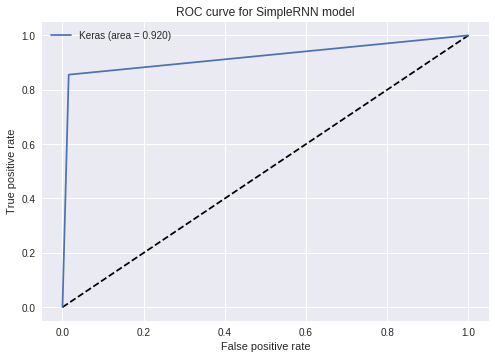

In [0]:
plot_roc_curve(y_test, y_predicted, "SimpleRNN")

Confusion matrix, without normalization
[[112028   1741]
 [  3608  21377]]


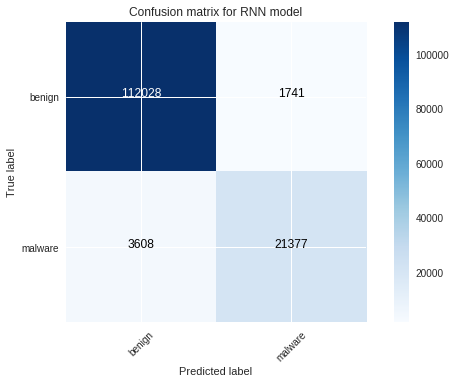

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(list(y_test), y_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['benign', 'malware'],
                      title='Confusion matrix for RNN model')

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

             precision    recall  f1-score   support

          0       0.97      0.98      0.98    113769
          1       0.92      0.86      0.89     24985

avg / total       0.96      0.96      0.96    138754



In [0]:
# just save predicted values in a different variables so we can use
# them for comparing with other models
y_predicted_rnn = y_predicted

### 3.2 Use a CNN for text classification
We now classify the same dataset using a 1D  CNN layer. We follow the same scheme by first converting the one hot encoded representation to an embedding, we add a 1D CNN layer with 64 kernels, followed by globall max pooling layer and then a single dense layer at the output. We are able to achieve the exact same results as  with the RNN i.e. 97% overall accuracy on the holdout set and 98% accuracy on benign URLs and 92% on malicious URLs.

In [0]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, GlobalMaxPooling1D
max_features = len(dct)
cnn_model = Sequential()
cnn_model.add(Embedding(max_features, 64, input_length=50))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    
print(cnn_model.summary())

history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 64)            11456     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            20544     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 32,065
Trainable params: 32,065
Non-trainable params: 0
_________________________________________________________________
None
Train on 225368 samples, validate on 56342 samples
Epoch 1/100
225368/225368 [==============================] - 10s 45us/step - loss:

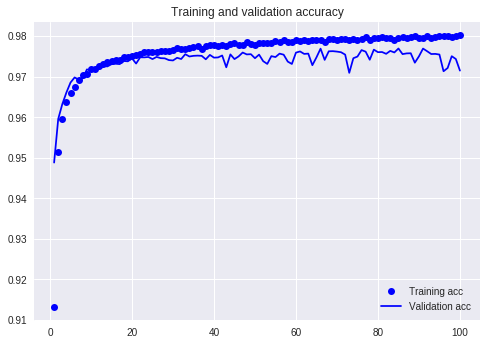

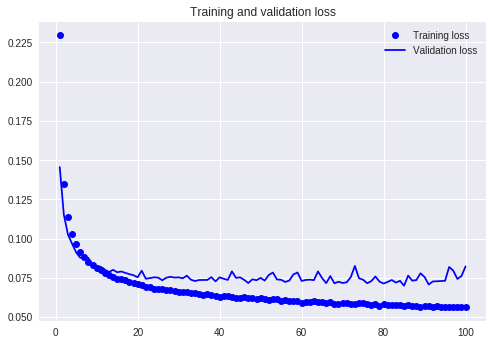

In [0]:
#plot model training results
plot_model_training_results(history)

In [0]:
# determine accuracy on holdout set
y_predicted = cnn_model.predict_classes(X_test)

# the output is provided as a list of lists (as if the output of the classifier 
# would have been multidimensional (binary classifier as a special case of
# multiclass classifier)) so flatten out this list of list
y_predicted = [item for sublist in y_predicted for item in sublist]

accuracy = np.mean(y_predicted == y_test)
print("Accuracy of the CNN model on the holdout set of size {} is {}".format(len(y_test), accuracy))

Accuracy of the CNN model on the holdout set of size 138754 is 0.9705449932974906


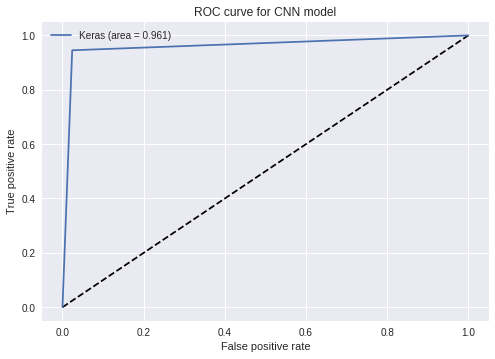

In [0]:
plot_roc_curve(y_test, y_predicted, "CNN")

Confusion matrix, without normalization
[[111048   2721]
 [  1366  23619]]


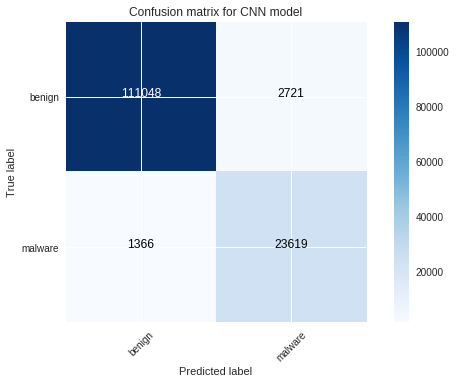

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(list(y_test), y_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['benign', 'malware'],
                      title='Confusion matrix for CNN model')


In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

             precision    recall  f1-score   support

          0       0.99      0.98      0.98    113769
          1       0.90      0.95      0.92     24985

avg / total       0.97      0.97      0.97    138754



In [0]:
# just save predicted values in a different variables so we can use
# them for comparing with other models
y_predicted_cnn = y_predicted

### 3.3 Comparison betwen SimpleRNN and CNN for text classificiation
We observe from the accuracy scores that the accuracy of the CNN and RNN model are very similar i.e. 98% and 97% respectively. However, the CNN does a better job at correctly identifying the malicious URLs at 92% as compared to 86% for simpleRNN. This is also reflected in the better AUC value for CNN i.e. 0.961 as compared to RNN i.e. 0.920. In the context of this problem, it is pobably more important to identify the "true" malicious URLs so we should go with the CNN here. Although it is entirely possible that with some tuning (adding more layers, dropout etc) the SimpleRNN (or an LSTM is also worth trying) may perform equally well as a CNN. Another advantage that CNN has that in this case the training time for CNN was much lesser than the training time for RNN.

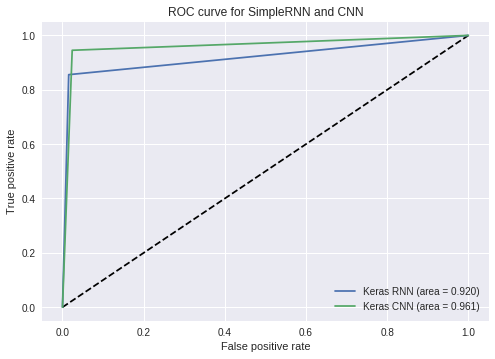

In [0]:
fpr_keras_rnn, tpr_keras_rnn, thresholds_keras_rnn = roc_curve(y_test, y_predicted_rnn)
fpr_keras_cnn, tpr_keras_cnn, thresholds_keras_cnn = roc_curve(y_test, y_predicted_cnn)
  
auc_keras_rnn = auc(fpr_keras_rnn, tpr_keras_rnn)
auc_keras_cnn = auc(fpr_keras_cnn, tpr_keras_cnn)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_rnn, tpr_keras_rnn, label='Keras RNN (area = {:.3f})'.format(auc_keras_rnn))
plt.plot(fpr_keras_cnn, tpr_keras_cnn, label='Keras CNN (area = {:.3f})'.format(auc_keras_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for SimpleRNN and CNN')
plt.legend(loc='best')
plt.show()


False